# deepctr

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
from copy import deepcopy
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from hyperopt import hp
from deepctr.models import xDeepFM
from deepctr.inputs import  SparseFeat, DenseFeat, get_feature_names
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, LE, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
ecd = LE(feature_col, bin_col=bin_col, class_col=class_col)

ecd.fit(train_df, verbose=1)
ecd.fit(test_df, verbose=1)

x_train_arr = ecd.transform(train_df, verbose=1)
x_test_arr = ecd.transform(test_df, verbose=1)

del train_df, test_df

600000it [00:10, 58193.82it/s]
400000it [00:07, 56769.46it/s]
600000it [00:10, 56572.90it/s]
400000it [00:07, 56965.51it/s]


In [5]:
# x_train_df = pd.DataFrame(data=x_train_arr, columns=feature_col)
# x_test_df = pd.DataFrame(data=x_test_arr, columns=feature_col)

In [6]:
def col_func(vocabulary, sparse_features, dense_features, k=5):
    # sparse
    feature_col = list()
    for f in sparse_features:
        feature_col.append(SparseFeat(f, vocabulary_size=vocabulary[f], embedding_dim=k))
    for f in dense_features:
        feature_col.append(DenseFeat(f, 1))

    dnn_f = feature_col
    linear_f= feature_col
    fn = get_feature_names(linear_f + dnn_f)
    return dnn_f, linear_f, fn

In [7]:
def xdeepfm(vocabulary, k, loss, metrics, optimizer, 
            num_deep_layer=2, num_neuron=256,
            num_cin_layer=2, num_cin=128,**kwargs):
    
    dnn_f, linear_f, _ = col_func(vocabulary, sparse_features=class_col, dense_features=bin_col, k=k)
    tf.random.set_seed(1024)
    model = xDeepFM(linear_feature_columns=linear_f,
                    dnn_feature_columns=dnn_f, 
                    cin_layer_size=tuple(num_cin for _ in range(num_cin_layer)),
                    dnn_hidden_units=tuple(num_neuron for _ in range(num_deep_layer)),
                    **kwargs)
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

In [8]:
def mkinput(input_arr, feature_col):
    return dict(zip(feature_col, input_arr.T))

# Search Max LR

see - ./main/main_8_xdeepfm_relu.ipynb

# fit one

In [9]:
def cv_score(batch_size, epochs, nflod, base_lr, max_lr, model_params, model_func, verbose=1):
    clr = CyclicLR(base_lr=0.1**(base_lr),
                   max_lr = 0.1**(max_lr), 
                   step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
                   mode='triangular2',
                   gamma=1.0)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=2, mode='max', restore_best_weights=True)

    fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': verbose, 'callbacks':[es, clr]}

    model = model_func(**model_params)

    cv = CV(model, nflod, random_state=2333)

    score = cv.fit(x=mkinput(x_train_arr, feature_col),
                   y=y_train,
                   metrics_func=roc_auc_score,
                   split_method=StratifiedKFold,
                   fit_params=fit_param,
                   eval_param={'batch_size':batch_size},
                   use_proba=False, 
                   verbose=verbose,
                   fit_use_valid=True)

    tf.keras.backend.clear_session()
    print(score)

# tunning

In [13]:
batch_size = 8192
epochs = 100
nflod = 5
seed = 2333

# fit param

clr = CyclicLR(base_lr=0.1**(4.5),
               max_lr = 0.1**(3.5),
               step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary': ecd.get_vocabulary(),
                   'loss': 'binary_crossentropy',
                   'metrics': ['AUC'], 
                   'optimizer': 'Adam',
                   'dnn_activation': 'mish', 
                   'cin_activation': 'linear',
                   'dnn_use_bn': False, 
                   'num_deep_layer': 2, 
                   'num_neuron': 256, 
                   'num_cin_layer': 2}

ss = {
    'num_cin': (hp.choice, (64, 100)),
    'k': (hp.choice, (5, 6, 7, 8, 9, 10)),
    'l2_reg_linear': (hp.loguniform, (-20, 0)),
    'l2_reg_embedding': (hp.loguniform, (-7.5, -2.5)),
    'l2_reg_dnn': (hp.loguniform, (-20, -7.5)),
    'l2_reg_cin': (hp.loguniform, (-15, 0)),
    'dnn_dropout': (hp.loguniform, (-20, -1))
}


# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=mkinput(x_train_arr, feature_col),
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=seed,
                model=xdeepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7888, param {'dnn_dropout': 1.9918564724051977e-08, 'k': 5, 'l2_reg_cin': 0.02866502814228341, 'l2_reg_dnn': 5.921395742766323e-05, 'l2_reg_embedding': 0.004182340363846039, 'l2_reg_linear': 0.022323042362670006, 'num_cin': 100}
new best, eval 3, score -0.7889, param {'dnn_dropout': 3.686442347410303e-08, 'k': 7, 'l2_reg_cin': 0.024882295597082184, 'l2_reg_dnn': 0.0002800996390096624, 'l2_reg_embedding': 0.0052265860917855, 'l2_reg_linear': 1.4518906129045601e-08, 'num_cin': 64}
new best, eval 4, score -0.7889, param {'dnn_dropout': 5.838692413804737e-09, 'k': 5, 'l2_reg_cin': 0.0026793344025634936, 'l2_reg_dnn': 0.00030873414861946696, 'l2_reg_embedding': 0.002944124909031167, 'l2_reg_linear': 8.941529742533272e-07, 'num_cin': 64}
new best, eval 5, score -0.7889, param {'dnn_dropout': 3.2644043196144683e-09, 'k': 5, 'l2_reg_cin': 0.00012089398672166199, 'l2_reg_dnn': 1.516213213798375e-08, 'l2_reg_embedding': 0.008781946799428996, 'l2_reg_linear': 0.02942938

{'dnn_dropout': 0.12093226519619354,
 'k': 1,
 'l2_reg_cin': 3.0671612088515794e-07,
 'l2_reg_dnn': 3.5470209962405707e-08,
 'l2_reg_embedding': 0.008584199119130368,
 'l2_reg_linear': 8.178521824338056e-08,
 'num_cin': 0}

In [14]:
log = tuning.log.get_log()

In [15]:
log.sort_values('score').head()

,score,update,usetime,dnn_dropout,k,l2_reg_cin,l2_reg_dnn,l2_reg_embedding,l2_reg_linear,num_cin
83,-0.788871,True,327.544835,0.120932,7,3.067161e-07,3.547021e-08,0.008584,8.178522e-08,64
71,-0.788870,True,335.740954,0.002142,7,3.459606e-06,1.126686e-08,0.008526,4.773663e-09,64
61,-0.788868,True,332.437814,0.000017,7,3.642839e-06,4.424970e-08,0.008400,3.456314e-08,64
72,-0.788868,False,335.522118,0.000006,7,8.762627e-06,1.096048e-08,0.008374,2.342059e-09,64
63,-0.788867,False,339.626841,0.000319,7,6.089791e-06,7.700200e-08,0.010081,3.304989e-08,64


In [16]:
log.sort_values('score').tail()

,score,update,usetime,dnn_dropout,k,l2_reg_cin,l2_reg_dnn,l2_reg_embedding,l2_reg_linear,num_cin
62,-0.788052,False,420.985516,2.013312e-05,7,0.000002,5.049405e-08,0.050953,3.272221e-08,100
50,-0.787951,False,429.974648,6.658904e-07,8,0.000031,9.841989e-08,0.052565,6.572907e-08,64
89,-0.787537,False,440.240897,1.248775e-01,7,0.000005,2.488532e-09,0.063537,6.412349e-06,64
31,-0.787392,False,429.176763,4.623215e-07,8,0.001396,7.742744e-09,0.077477,2.491803e-05,64
47,-0.786867,False,387.384027,3.176490e-03,5,0.000363,2.514018e-05,0.075735,2.341723e-01,100


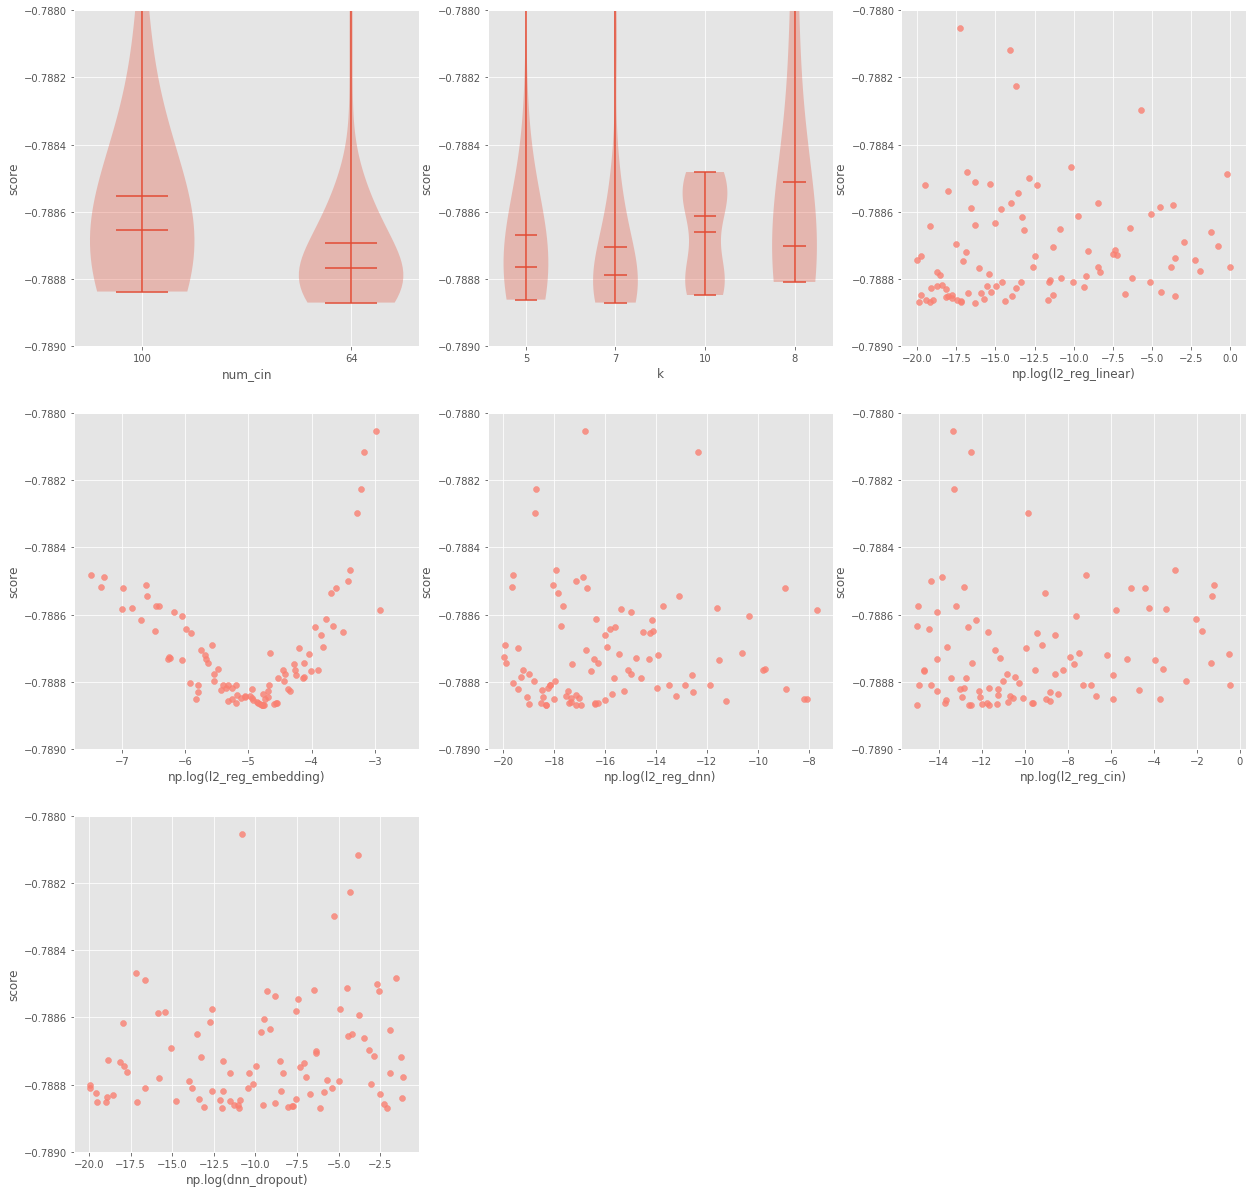

In [17]:
tuning.log.plot(score_interval=[-0.789, -0.788])

In [ ]:
seed = np.random.randint(2**32)
print(seed)

##  3355867947

In [ ]:
######
log.to_csv(f'/data/{seed}.csv', index=False)
#####

In [9]:
######
seed = 4293006264
log = pd.read_csv(f'/data/{seed}.csv')
#####

In [10]:
log.sort_values('score').head()

,score,update,usetime,dnn_dropout,k,l2_reg_cin,l2_reg_dnn,l2_reg_embedding,l2_reg_linear,num_cin
83,-0.788871,True,327.544835,0.120932,7,3.067161e-07,3.547021e-08,0.008584,8.178522e-08,64
71,-0.788870,True,335.740954,0.002142,7,3.459606e-06,1.126686e-08,0.008526,4.773663e-09,64
61,-0.788868,True,332.437814,0.000017,7,3.642839e-06,4.424970e-08,0.008400,3.456314e-08,64
72,-0.788868,False,335.522118,0.000006,7,8.762627e-06,1.096048e-08,0.008374,2.342059e-09,64
63,-0.788867,False,339.626841,0.000319,7,6.089791e-06,7.700200e-08,0.010081,3.304989e-08,64


# stacking

In [15]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_param = {'vocabulary': ecd.get_vocabulary(),
               'loss': 'binary_crossentropy',
               'metrics': ['AUC'], 
               'optimizer': 'Adam',
               'dnn_activation': 'mish', 
               'cin_activation': 'linear',
               'dnn_use_bn': False, 
               'num_deep_layer': 2, 
               'num_neuron': 256, 
               'num_cin_layer': 2}
# callbacks
clr = CyclicLR(
    base_lr=0.1**(5),
    max_lr = 0.1**(3.5), 
    step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=5,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = deepcopy(model_param)
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = xdeepfm(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=mkinput(x_train_arr, feature_col),
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=mkinput(x_test_arr, feature_col), pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    del model, cv
    tf.keras.backend.clear_session()

folds 0 is done, score is 0.7875652372062427
folds 1 is done, score is 0.7870680743326895
folds 2 is done, score is 0.7849924233505166
folds 3 is done, score is 0.7936217341155005
folds 4 is done, score is 0.7876845735328756
folds 5 is done, score is 0.7896293153326455
folds 6 is done, score is 0.781818421869275
folds 7 is done, score is 0.7975031558221355
folds 8 is done, score is 0.7838921685603937
folds 9 is done, score is 0.7859973595548153
folds 10 is done, score is 0.7909758851257376
folds 11 is done, score is 0.785337890873283
folds 12 is done, score is 0.7855095858243414
folds 13 is done, score is 0.7926566145377663
folds 14 is done, score is 0.7956262390778877
folds 15 is done, score is 0.7935562020258954
folds 16 is done, score is 0.7959437345305127
folds 17 is done, score is 0.7900045730795403
folds 18 is done, score is 0.7862968033776762
folds 19 is done, score is 0.7888962964832387
folds 20 is done, score is 0.7860045013403774
folds 21 is done, score is 0.788141107428345
f

folds 18 is done, score is 0.7863745889603009
folds 19 is done, score is 0.789029361530797
folds 20 is done, score is 0.786006210111156
folds 21 is done, score is 0.7881363608428487
folds 22 is done, score is 0.7837867213379844
folds 23 is done, score is 0.7905212060498314
folds 24 is done, score is 0.7913142509496676
folds 25 is done, score is 0.790589673720005
folds 26 is done, score is 0.7896613730408433
folds 27 is done, score is 0.7941296917879924
folds 28 is done, score is 0.7855794847726032
folds 29 is done, score is 0.790491105395346
folds 30 is done, score is 0.791818791080602
folds 31 is done, score is 0.7917302417025596
folds 32 is done, score is 0.7836064679281541
folds 33 is done, score is 0.7972238521266574
folds 34 is done, score is 0.787699543533287
folds 35 is done, score is 0.7830896596993218
folds 36 is done, score is 0.7868145171089727
folds 37 is done, score is 0.8007710284851208
folds 38 is done, score is 0.7948193736633979
folds 39 is done, score is 0.78986264095

In [16]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save(f'/data/{seed}stacking1.npy', pred_arr)
pred_arr.shape

(600000, 5)

In [17]:
pred = np.array(pred_lst).squeeze().T
np.save(f'/data/{seed}predict.npy', pred)
pred.shape

(400000, 5)

In [19]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv(f'/data/main_8_xdeepfm_mish_{seed}.csv')